In [194]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE

import pickle

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.models import load_model

import copy

In [182]:
with open('../lipika/lgbm_test_no_smote.pickle', 'rb') as file:  
    LGBM_test_dict = pickle.load(file)
    
with open('../lipika/lgbm_train_no_smote.pickle', 'rb') as file:  
    LGBM_train_dict = pickle.load(file)

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 0.20.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 0.20.1 when using versio

In [183]:
key_test = list(LGBM_test_dict.keys())[0]
key_train = list(LGBM_train_dict.keys())[0]
LGBM_test = LGBM_test_dict[key_test]
LGBM_train = LGBM_train_dict[key_train]

NN = load_model('../lipika/NN_final_model.h5')

data_train = pd.read_csv("../lipika/cleaned_2013_14", low_memory = False);
data_test = pd.read_csv("../lipika/cleaned_2015", low_memory = False);
data_test = data_test.dropna()
data_train = data_train.dropna()


LGBM_test = LGBM_test[LGBM_test.int_rate < 0.5]
LGBM_train = LGBM_train[LGBM_train.int_rate < 0.5]
data_test = data_test[data_test.int_rate < 0.5]
data_train = data_train[data_train.int_rate < 0.5]

In [184]:
data_train = pd.read_csv("../lipika/cleaned_2013_14", low_memory = False);
data_test = pd.read_csv("../lipika/cleaned_2015", low_memory = False);
data_test = data_test.dropna()
data_train = data_train.dropna()

In [185]:
LGBM_train['annualized_amnt'] = LGBM_train['amnt']
LGBM_test['annualized_amnt'] = LGBM_test['amnt']
data_train['int_rate_real'] = data_train.int_rate
data_test['int_rate_real'] = data_test.int_rate

data_train.int_rate = data_train.int_rate/np.amax(data_train.int_rate)
data_train['model_term'] = data_train.term/np.amax(data_train.term)
data_train.dti = data_train.dti/np.amax(data_train.dti)
data_train.revol_util = data_train.revol_util/np.amax(data_train.revol_util)

data_test.int_rate = data_test.int_rate/np.amax(data_test.int_rate)
data_test['model_term'] = data_test.term/np.amax(data_train.term)
data_test.dti = data_test.dti/np.amax(data_test.dti)
data_test.revol_util = data_test.revol_util/np.amax(data_test.revol_util)

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [187]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

cols_to_drop_training = ['loan_status', 'paid', 'amnt', 'total_pymnt', 
                         'term_adj', 'term', 'zip_code', 'int_rate_real']
x_train, y_train = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)


def create_df(data_1, data_2, penal = 0.5):
    df = pd.DataFrame(data_1)
    df['proba'] = df.proba.map(lambda x: x[0])
    df['pred'] = df.pred.map(lambda x:x[0])
    
    df['int_rate'] = data_2['int_rate_real']
    df['amnt'] = data_2['amnt']
    df['total_pymnt'] = data_2['total_pymnt']
    df['term_adj'] = data_2['term_adj']
    df['ROI'] = (((1 + df['int_rate'])*(1-df['proba']))+(df['proba']*drr*penal))-1

    df['Real_ROI'] = df['amnt']*(((df['total_pymnt']/df['amnt'])**(1/df['term_adj']))-1)
    df['annualized_amnt'] = df['amnt'] #*(1/df['term_adj'])
    
    df['zip_code'] = data_2['zip_code']
    
    return df

distress = data_train[data_train.paid == 1]
drr = (np.sum(distress.total_pymnt)/np.sum(distress.amnt))**(1/np.mean(distress.term))
print('Distressed Return Rate: ', drr)

Distressed Return Rate:  0.8999757837386154


In [188]:
NN_train_predictions = (NN.predict(x_train))
NN_test_predictions = (NN.predict(x_test))
NN_train_class = np.where(NN_train_predictions > 0.50, 1, 0)
NN_test_class = np.where(NN_test_predictions > 0.50, 1, 0)

In [189]:
train_data = {'proba' : NN_train_predictions.tolist(), 'pred' : NN_train_class.tolist(), 'true_val' : y_train}
test_data = {'proba' : NN_test_predictions.tolist(), 'pred' : NN_test_class.tolist(), 'true_val' : y_test}
NN_train = create_df(train_data, data_train)
NN_test =  create_df(test_data, data_test)

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


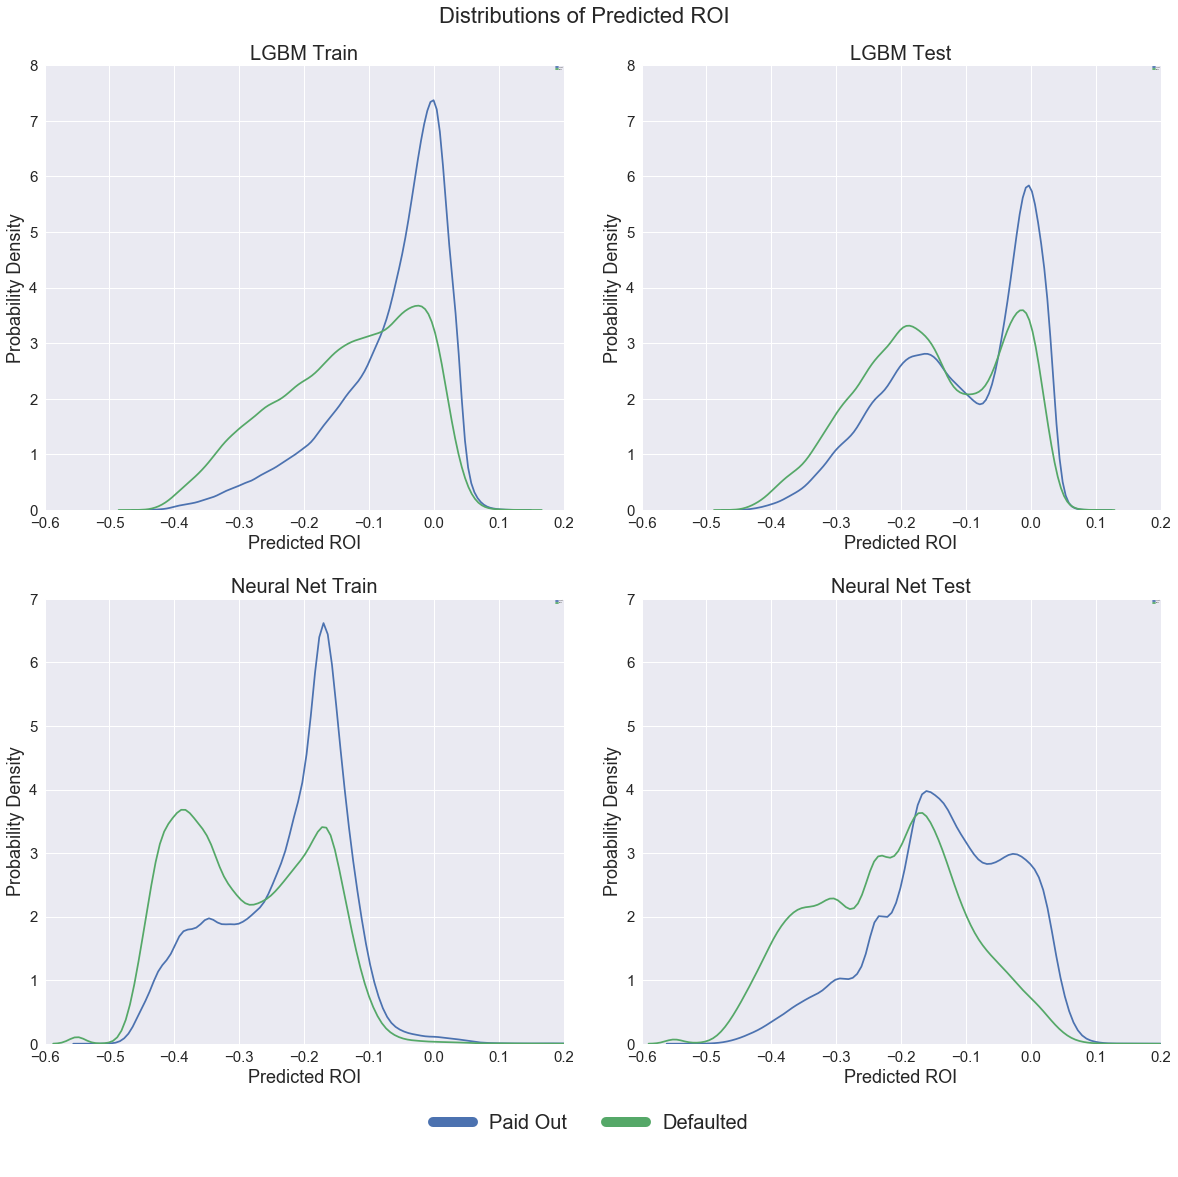

In [196]:
models = [LGBM_train, LGBM_test, NN_train, NN_test]
titles = ['LGBM Train', 'LGBM Test', 'Neural Net Train', 'Neural Net Test']
fig = plt.figure(figsize=(20, 18)) 
fig.subplots_adjust(hspace=0.2, wspace=0.15)
plt.suptitle('Distributions of Predicted ROI', size = 22,  y=0.925)

for n, model in enumerate(models):
    ax = plt.subplot(2,2, n+1)
    sns.kdeplot(model.loc[model.true_val == 0,'ROI'], label = 'Paid Out', ax=ax);
    sns.kdeplot(model.loc[model.true_val == 1,'ROI'], label = 'Defaulted', ax=ax);
    ax.set_xlim(-0.6, 0.2)
    if n <= 1:
        ax.set_ylim(0, 8)
    else:
        ax.set_ylim(0, 7)
        
    ax.tick_params(labelsize = 15)
    ax.set_xlabel('Predicted ROI', fontsize = 18)
    ax.set_ylabel('Probability Density', fontsize = 18)
    ax.set_title('{0}'.format(titles[n]), fontsize = 20)
    ax.legend(loc = 'best', fontsize = -1)
    
handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(10) for ha in handles ]
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 20, bbox_to_anchor = (0.41, 0.02))
plt.show()

In [197]:
NN_train = NN_train.sort_values(by=['ROI'], ascending=False)
NN_test = NN_test.sort_values(by=['ROI'], ascending=False)
LGBM_train = LGBM_train.sort_values(by=['ROI'], ascending=False)
LGBM_test = LGBM_test.sort_values(by=['ROI'], ascending=False)

def create_strategy_curve(df):
    df['cumsum_prop_loans'] = df.amnt.cumsum()/np.sum(df.amnt)
    df['cumsum_ROI'] = df.Real_ROI.cumsum()/df.annualized_amnt.cumsum()
    return df

NN_train = create_strategy_curve(NN_train)
NN_test = create_strategy_curve(NN_test)
LGBM_train = create_strategy_curve(LGBM_train)
LGBM_test = create_strategy_curve(LGBM_test)

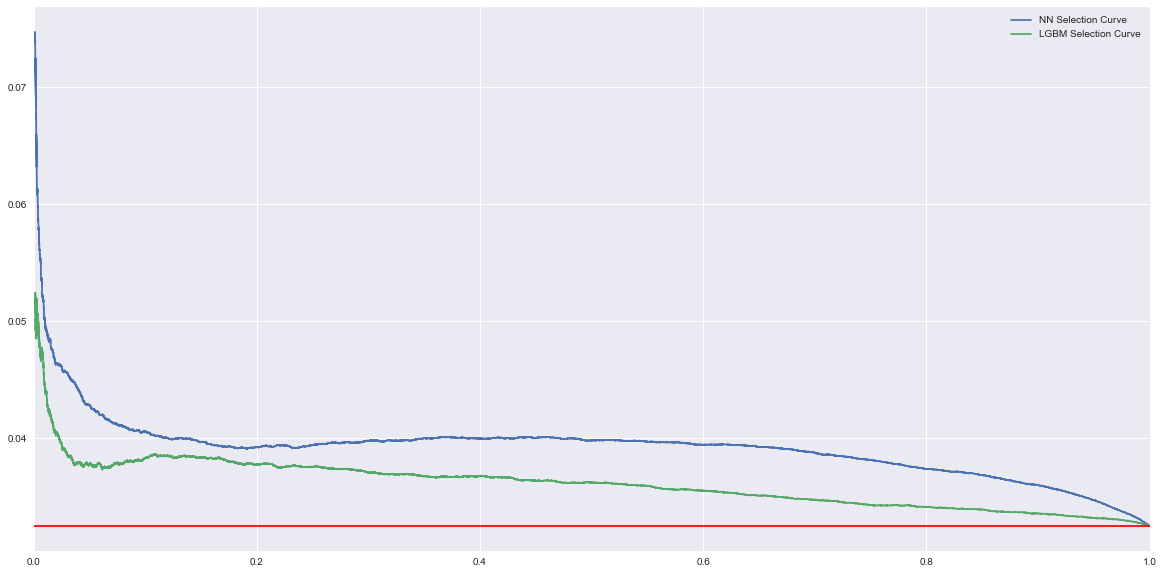

In [198]:
i = 1000

plt.figure(figsize=(20,10))
plt.plot(NN_test.cumsum_prop_loans[i:], NN_test.cumsum_ROI[i:], label = 'NN Selection Curve')
plt.plot(LGBM_test.cumsum_prop_loans[i:], LGBM_test.cumsum_ROI[i:], label = 'LGBM Selection Curve')
plt.axhline(np.sum(NN_test.Real_ROI)/np.sum(NN_test.annualized_amnt), color = 'r')
plt.legend()
plt.xlim(0,1)
plt.show()

In [204]:
accuracy_score(NN_test.true_val, NN_test.pred)

0.7215627820079978

In [ ]:
NN_test.to_csv('NN_test')
NN_train.to_csv('NN_train')